<a href="https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/Conceptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('BScThesis/')

In [0]:
!pip3 install torch torchvision

In [192]:
!git clone https://github.com/wiatrak2/BScThesis

Cloning into 'BScThesis'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 259 (delta 41), reused 42 (delta 16), pack-reused 179
Receiving objects: 100% (259/259), 20.11 MiB | 8.65 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import pickle
import sympy
from collections import defaultdict, namedtuple
import copy

In [0]:
from mnist_m import Mnist_M
from datasets_merge import Merge_Datasets
import models
import trainer
import domain_trainer
from test_model import test_model
import plots
import test

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  return torch.from_numpy(np.tile(img, (3,1,1)))

In [0]:
batch_size=128
num_workers=1

In [0]:
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                           transforms.Lambda(convertMnist)
                       ])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)



In [0]:
def printMnist3D(image):
  image = image.numpy()
  image = image * 0.3081 + 0.1307
  plt.imshow(image.transpose(1,2,0), cmap='gray')

8


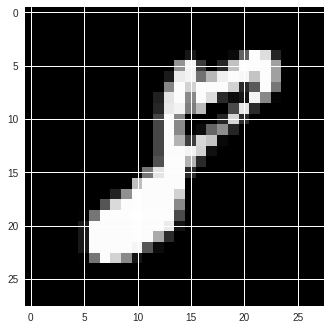

In [12]:
trainiter = iter(train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [0]:
log_interval = 100

In [0]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.01
momentum=0.9

In [0]:
mnist_m_transform = transforms.Compose([
                           transforms.Normalize(3*[0.1307], 3*[0.3081]),
                       ])
mnist_m_train = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',
                        transform=mnist_m_transform)
mnist_m_test = Mnist_M('drive/My Drive/BScThesis/keras_mnistm.pkl',train=False,
                     transform=mnist_m_transform)
mnist_m_train_loader = torch.utils.data.DataLoader(mnist_m_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_m_test_loader = torch.utils.data.DataLoader(mnist_m_test,
                                                  batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)



tensor(9)


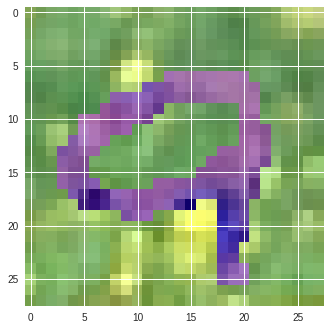

In [17]:
trainiter = iter(mnist_m_train_loader)
images, labels = trainiter.next()
printMnist3D(images[0])
print(labels[0])

In [0]:
Models = namedtuple('Models', ['model_f', 'model_c', 'model_d'])
Optims = namedtuple('Optims', ['optim_f', 'optim_c', 'optim_d'])
Criterions = namedtuple('Criterions', ['criterion', 'criterion_domain'])
Loaders = namedtuple('Loaders', ['train_loader', 'train_loader_domain',
                                'source_test_loader', 'target_test_loader',
                                'merged_test_loader'])

In [0]:
mnist_ext_train = Merge_Datasets([train_set, mnist_m_train])
mnist_ext_test = Merge_Datasets([test_set, mnist_m_test])
mnist_ext_train_loader = torch.utils.data.DataLoader(mnist_ext_train, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
mnist_ext_test_loader = torch.utils.data.DataLoader(mnist_ext_test, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)




In [0]:
loaders = Loaders(train_loader, mnist_m_train_loader,
                 test_loader, mnist_m_test_loader, mnist_ext_test_loader)

In [0]:
criterion = F.nll_loss
criterion_domain = F.nll_loss

In [0]:
criterions = Criterions(criterion, criterion_domain)

In [0]:
epochs=10

# Trainings

In [0]:
model_f = models.MnistFeatureExtractor().to(device)
model_c = models.MnistClassPredictor().to(device)
model_d = models.MnistDomain().to(device)
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum, nesterov=True)

train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer = trainer.Trainer(train_models, optims, criterions, device,
                                tune_lr=True)

In [42]:
test_history = defaultdict(lambda:[])
model_trainer.train(epochs, loaders, test_history=test_history)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.288124, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.687243, lr: 0.00865 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.394260, lr: 0.00766 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.302668, lr: 0.00690 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.280512, lr: 0.00630 lambd: 0.40253

Target Domain Test set: Average loss: 1.5167, Accuracy: 5724/10000 (57%)
Source Domain Test set: Average loss: 0.1088, Accuracy: 9652/10000 (97%)
Domains predictor:  Accuracy: 15240/20000 (76%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.213200, lr: 0.00595 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.226828, lr: 0.00551 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.238491, lr: 0.00514 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.249446, lr: 0.00483 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.204201, lr: 0.00455

In [0]:
model_f_simple = models.MnistFeatureExtractor().to(device)
model_c_simple = models.MnistClassPredictor().to(device)
model_d_simple = models.DomainPredictor().to(device)
optim_f_simple = optim.SGD(model_f_simple.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c_simple = optim.SGD(model_c_simple.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d_simple = optim.SGD(model_d_simple.parameters(), lr=lr, momentum=momentum, nesterov=True)

train_models_simple = Models(model_f_simple, model_c_simple, model_d_simple)
optims_simple = Optims(optim_f_simple, optim_c_simple, optim_d_simple)

In [0]:
model_trainer_simple = trainer.Trainer(train_models_simple, optims_simple, criterions, device,
                                train_domain=False, tune_lr=True)

In [68]:
test_history_s = defaultdict(lambda:[])
model_trainer_simple.train(epochs, loaders, test_history=test_history_s)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.324746, lr: 0.01000 lambd: 1.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.593118, lr: 0.00865 lambd: 1.00000
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.306642, lr: 0.00766 lambd: 1.00000
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.248127, lr: 0.00690 lambd: 1.00000
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.266532, lr: 0.00630 lambd: 1.00000

Target Domain Test set: Average loss: 1.3999, Accuracy: 5642/10000 (56%)
Source Domain Test set: Average loss: 0.0911, Accuracy: 9716/10000 (97%)
Domains predictor:  Accuracy: 11039/20000 (55%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.192934, lr: 0.00595 lambd: 1.00000
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.216181, lr: 0.00551 lambd: 1.00000
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.240738, lr: 0.00514 lambd: 1.00000
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.315474, lr: 0.00483 lambd: 1.00000
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.341983, lr: 0.00455

In [0]:
model_f_no_gr = models.MnistFeatureExtractor().to(device)
model_c_no_gr = models.MnistClassPredictor().to(device)
model_d_no_gr = models.DomainPredictor().to(device)
optim_f_no_gr = optim.SGD(model_f_no_gr.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c_no_gr = optim.SGD(model_c_no_gr.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d_no_gr = optim.SGD(model_d_no_gr.parameters(), lr=lr, momentum=momentum, nesterov=True)

train_models_no_gr = Models(model_f_no_gr, model_c_no_gr, model_d_no_gr)
optims_no_gr = Optims(optim_f_no_gr, optim_c_no_gr, optim_d_no_gr)

In [0]:
model_trainer_no_gr = trainer.Trainer(train_models_no_gr, optims_no_gr, criterions, device,
                                train_domain=True, tune_lr=True)

In [74]:
test_history_no_gr = defaultdict(lambda:[])
model_trainer_no_gr.train(epochs, loaders, test_history=test_history_no_gr)

Train Epoch: 					1 [0/60000 (0%)]	Loss: 2.302624, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/60000 (21%)]	Loss: 0.655703, lr: 0.00865 lambd: 0.10626
Train Epoch: 					1 [25600/60000 (43%)]	Loss: 0.428860, lr: 0.00766 lambd: 0.21015
Train Epoch: 					1 [38400/60000 (64%)]	Loss: 0.330753, lr: 0.00690 lambd: 0.30951
Train Epoch: 					1 [51200/60000 (85%)]	Loss: 0.264159, lr: 0.00630 lambd: 0.40253

Target Domain Test set: Average loss: 2.1701, Accuracy: 2646/10000 (26%)
Source Domain Test set: Average loss: 0.0950, Accuracy: 9700/10000 (97%)
Domains predictor:  Accuracy: 19889/20000 (99%)

Train Epoch: 					2 [0/60000 (0%)]	Loss: 0.272863, lr: 0.00595 lambd: 0.46212
Train Epoch: 					2 [12800/60000 (21%)]	Loss: 0.213292, lr: 0.00551 lambd: 0.54178
Train Epoch: 					2 [25600/60000 (43%)]	Loss: 0.208665, lr: 0.00514 lambd: 0.61276
Train Epoch: 					2 [38400/60000 (64%)]	Loss: 0.171963, lr: 0.00483 lambd: 0.67507
Train Epoch: 					2 [51200/60000 (85%)]	Loss: 0.138183, lr: 0.00455

# Conceptors

## Functions

In [0]:
def get_input_mtx(loader, model, c_size):
  X = np.zeros(c_size).T
  for batch_idx, (data, labels) in enumerate(loader):
    data = data.to(device)
    idx = batch_idx * loader.batch_size
    X[idx:idx+loader.batch_size] = model(data).cpu().detach().numpy()
  return X.T

In [0]:
def get_conceptor(X, alpha):
  R = np.matmul(X, X.T) * (1/X.shape[0])
  IdX = np.identity(X.shape[0])
  return np.matmul(R, np.linalg.inv((R + alpha**(-2) * IdX)))

In [0]:
def get_not_conceptor(C):
  return np.identity(C.shape[0]) - C

In [0]:
def get_or_from_X(X_i, X_j, alpha):
  IdX = np.identity(X_i.shape[0])
  R_i = np.matmul(X_i, X_i.T) * (1/X_i.shape[0])
  R_j = np.matmul(X_j, X_j.T) * (1/X_j.shape[0])
  return np.matmul(R_i + R_j, np.linalg.inv((R_i + R_j + alpha**(-2) * IdX)))

 $\text{If } R = U \Sigma U ^ { \top }\text { is the SVD of } R ,\text { then the  SVD of } C \text { is given as } U S U ^ { \top }, \\\text{where singular values}  s _ { i } \text { of } C \text { can be written in terms of the singular values } \sigma _ { i } \text { of } R : s _ { i } = \frac{\sigma _ { i }}{ \sigma _ { i } + \alpha ^ { - 2 }  }\in [ 0,1 )$ \
 $s_{i} = \frac{\sigma _ { i }}{ \sigma _ { i } + \alpha ^ { - 2 }  } \\ \sigma _ { i } + \alpha ^ { - 2 }  = \frac{\sigma_{i}}{s_{i}} \\ \frac{\sigma _ { i } + \alpha ^ { - 2 } }{\sigma_{i}} = \frac{1}{s_{i}} \\ \frac{\alpha ^ { - 2 }}{\sigma_{i}} = \frac{1}{s_{i}} - 1 \\ \frac{1}{\sigma_{i}} = \frac{1-s_{i}}{s_{i}\cdot \alpha^{-2}} \\ \sigma_{i} = \frac {s_{i}\cdot \alpha^{-2}}{1-s_{i}}
 $

In [0]:
def get_R(C, alpha):
  U, S, U_T = np.linalg.svd(C)
  Sigma = (S * alpha**(-2)) / (1 - S)
  return U.dot(np.diag(Sigma).dot(U_T))

In [0]:
def get_or_conceptor(C_i, C_j, alpha):
  R_i, R_j = get_R(C_i, alpha), get_R(C_j, alpha)
  IdX = np.identity(C_i.shape[0])
  return np.matmul(R_i + R_j, np.linalg.inv((R_i + R_j + alpha**(-2) * IdX)))

In [0]:
def get_and_conceptor(C_i, C_j, alpha):
  not_C_i, not_C_j = get_not_conceptor(C_i), get_not_conceptor(C_j)
  or_not_C = get_or_conceptor(not_C_i, not_C_j, alpha)
  return get_not_conceptor(or_not_C)

In [0]:
def get_diff_conceptor(C_i, C_j, alpha):
  return get_and_conceptor(get_not_conceptor(C_j), C_i, alpha)

$ { \text { We define the quota } Q ( C ) \text { of a conceptor to be the mean singular values: } }  { Q ( C ) : = \frac { 1 } { N } \sum _ { i = 1 } ^ { N } s _ { i } . \text { Intuitively, the quota measures the fraction of the total dimensions of the } } { \text { entire vector space that is claimed by } C . } $

In [0]:
def quota(C):
  U, S, U_T = np.linalg.svd(C)
  return np.sum(S) / len(S)

## Collecting data

In [0]:
img_dim = train_set[0][0].reshape(1,-1).shape[1]

In [0]:
X_mnist_data = get_input_mtx(train_loader, lambda x:x.reshape(x.shape[0],-1), (img_dim, len(train_set)))

In [0]:
X_mnist_m_data = get_input_mtx(mnist_m_train_loader, lambda x:x.reshape(x.shape[0],-1), (img_dim, len(train_set)))

In [0]:
X_mnist = get_input_mtx(train_loader, model_f, (320, len(train_set)))

In [0]:
X_mnist_m = get_input_mtx(mnist_m_train_loader, model_f, (320, len(train_set)))

In [0]:
X_mnist_simple = get_input_mtx(train_loader, model_f_simple, (320, len(train_set)))

In [0]:
X_mnist_m_simple = get_input_mtx(mnist_m_train_loader, model_f_simple, (320, len(train_set)))

In [0]:
X_mnist_no_gr = get_input_mtx(train_loader, model_f_no_gr, (320, len(train_set)))

In [0]:
X_mnist_m_no_gr = get_input_mtx(mnist_m_train_loader, model_f_no_gr, (320, len(train_set)))

## Collecting Conceptor matrices

In [0]:
apertures = np.arange(0.1, 1.1, 0.1)

In [0]:
mnist_data_conceptors = [get_conceptor(X_mnist_data, aperture) for aperture in apertures]

In [0]:
mnist_m_data_conceptors = [get_conceptor(X_mnist_m_data, aperture) for aperture in apertures]

In [0]:
mnist_conceptors = [get_conceptor(X_mnist, aperture) for aperture in apertures]

In [0]:
mnist_m_conceptors = [get_conceptor(X_mnist_m, aperture) for aperture in apertures]

In [0]:
mnist_simple_conceptors = [get_conceptor(X_mnist_simple, aperture) for aperture in apertures]

In [0]:
mnist_m_simple_conceptors = [get_conceptor(X_mnist_m_simple, aperture) for aperture in apertures]

In [0]:
mnist_no_gr_conceptors = [get_conceptor(X_mnist_no_gr, aperture) for aperture in apertures]

In [0]:
mnist_m_no_gr_conceptors = [get_conceptor(X_mnist_m_no_gr, aperture) for aperture in apertures]

## Results of Conceptors research

In [212]:
print('Apertures:\n', apertures)

Apertures:
 [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [208]:
print('Quota of Mnist Dataset Conceptors:\n', list(map(lambda x:quota(x), mnist_data_conceptors)))

Quota of Mnist Dataset Conceptors:
 [0.039163234694499255, 0.07450228496764093, 0.10216688919990509, 0.12372649468469869, 0.14069955778488805, 0.154291307522295, 0.16538105615907758, 0.17459346517249846, 0.18237205028346865, 0.18903522822098504]


In [209]:
print('Quota of Mnist M Dataset Conceptors:\n', list(map(lambda x:quota(x), mnist_m_data_conceptors)))

Quota of Mnist M Dataset Conceptors:
 [0.045612444895134184, 0.10792012234612966, 0.16617013948009757, 0.21701593645103223, 0.2609759596242729, 0.29925535261823755, 0.332942706151412, 0.3628899742097901, 0.38974660056803745, 0.4140113374872614]


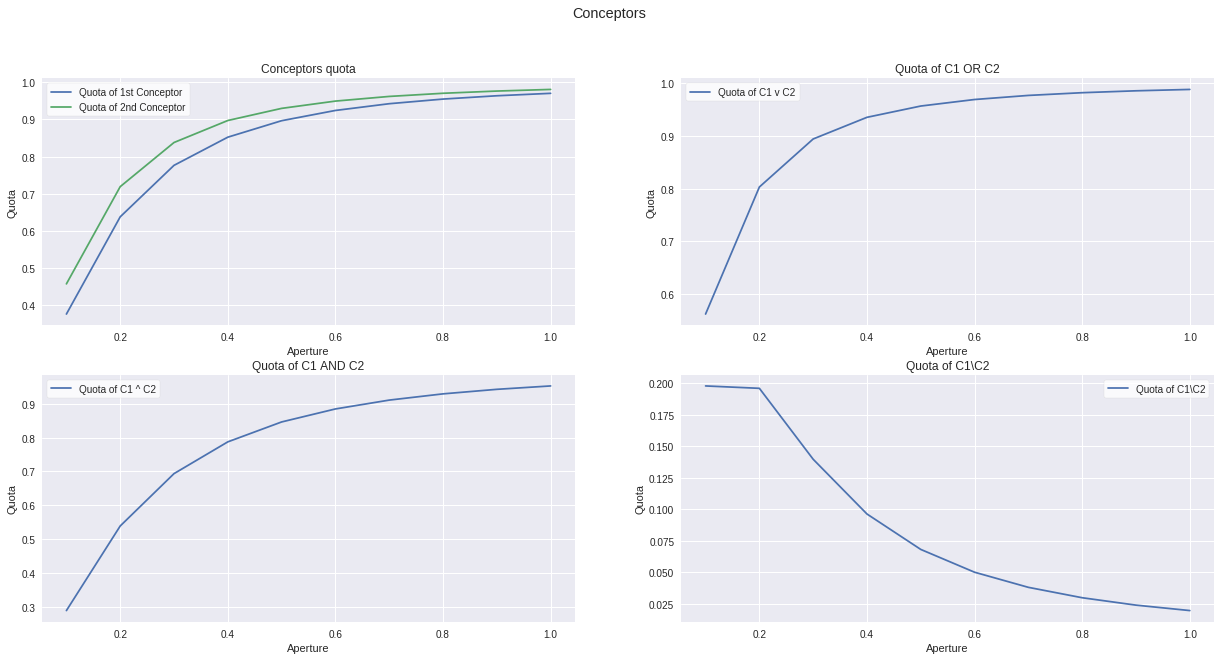

In [195]:
plots.plot_conceptors(mnist_conceptors, mnist_m_conceptors, apertures, quota, get_or_conceptor,
               get_and_conceptor, get_diff_conceptor)

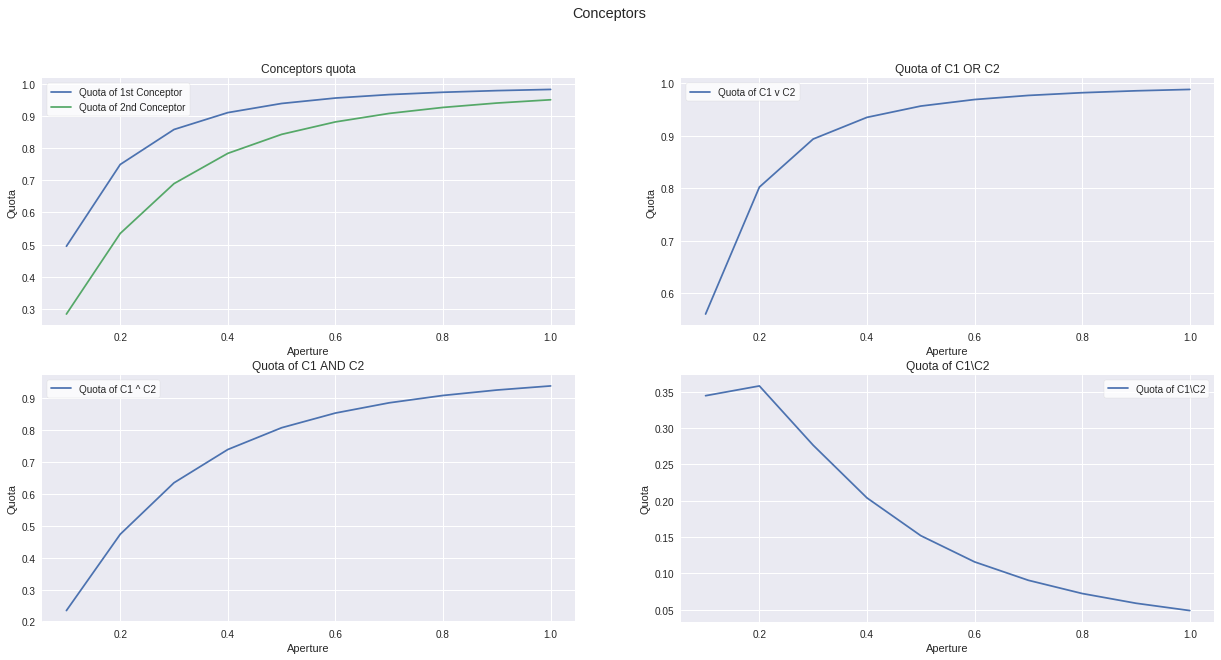

In [197]:
plots.plot_conceptors(mnist_simple_conceptors, mnist_m_simple_conceptors, apertures, quota, get_or_conceptor,
               get_and_conceptor, get_diff_conceptor)

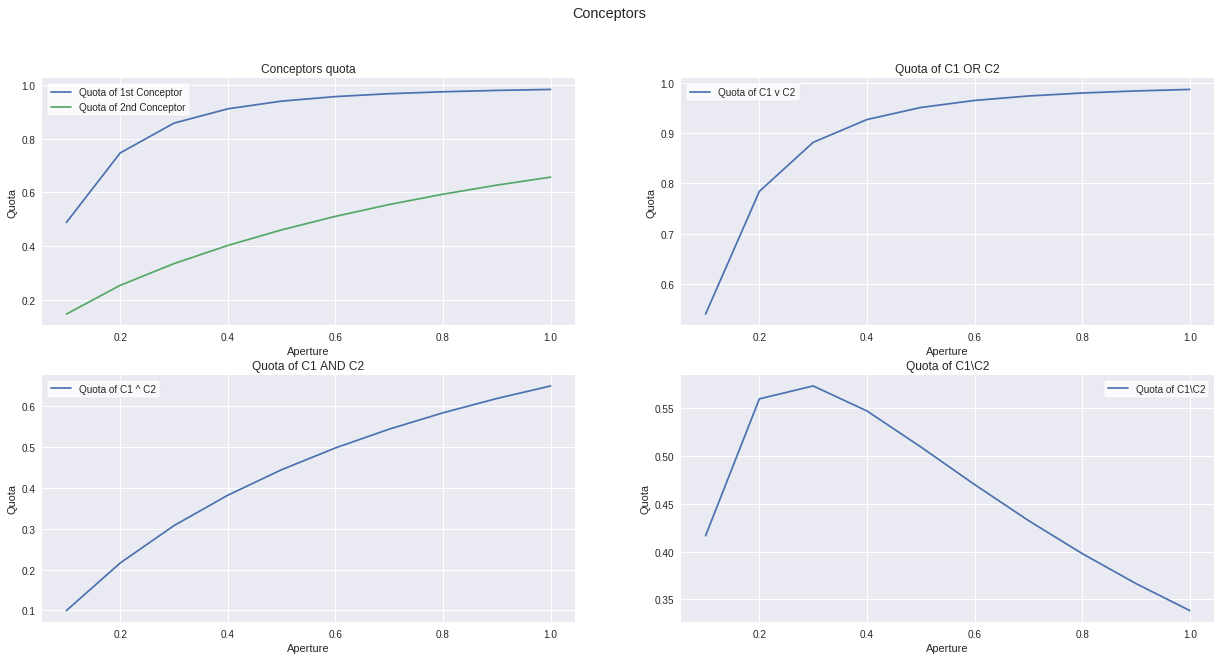

In [198]:
plots.plot_conceptors(mnist_no_gr_conceptors, mnist_m_no_gr_conceptors, apertures, quota, get_or_conceptor,
               get_and_conceptor, get_diff_conceptor)

In [0]:
a_num = 0

In [203]:
C_m = mnist_conceptors[a_num]
C_m_m = mnist_m_conceptors[a_num]
C_or = quota(get_or_conceptor(C_m, C_m_m, apertures[a_num]))
C_and = quota(get_and_conceptor(C_m, C_m_m, apertures[a_num]))

print('Mnist with GR\naperture: {}\nQuota for activations of last layer (Mnist): {}\nQuota for activations of last layer (Mnist M): {}\n\
Quota for activations of last layer (Mnist OR Mnist M): {}\nQuota for activations of last layer (Mnist AND MnistM): {}\n'.format(apertures[a_num],quota(C_m),
                                                                                                                                quota(C_m_m), C_or, C_and))

Mnist with GR
aperture: 0.1
Quota for activations of last layer (Mnist): 0.37638323993384615
Quota for activations of last layer (Mnist M): 0.4575346772338566
Quota for activations of last layer (Mnist OR Mnist M): 0.562008028792457
Quota for activations of last layer (Mnist AND MnistM): 0.2884840949807302

